<a href="https://colab.research.google.com/github/elisasanzani/MachineLearningProject/blob/main/Zboson_decay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import os
import time

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns

np.random.seed() # shuffle random seed generator



Getting data from my GitHub.
The datasets I am using are from [CERN Open Data](http://opendata.cern.ch/record/545)

These data were selected to obtain
* **a candidate Z boson event into 2 muons**: an event was selected if there were two muons in the event with pT > 20 GeV and |eta| < 2.1 and the invariant mass of the two muons was > 60 GeV and < 120 GeV.
* **a candidate Z boson event into 2 electrons**: an event was selected if there were two electrons in the event with pT > 25 GeV and the invariant mass of the two electrons was > 60 GeV and < 120 GeV





In [3]:
!wget https://raw.githubusercontent.com/elisasanzani/MachineLearningProject/main/Zee.csv -O Zee.csv
!wget https://raw.githubusercontent.com/elisasanzani/MachineLearningProject/main/Zmumu.csv -O Zmumu.csv

--2023-10-17 05:10:19--  https://raw.githubusercontent.com/elisasanzani/MachineLearningProject/main/Zee.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1445651 (1.4M) [text/plain]
Saving to: ‘Zee.csv’

Zee.csv             100%[===================>]   1.38M  --.-KB/s    in 0.07s   

2023-10-17 05:10:19 (20.6 MB/s) - ‘Zee.csv’ saved [1445651/1445651]

--2023-10-17 05:10:19--  https://raw.githubusercontent.com/elisasanzani/MachineLearningProject/main/Zmumu.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 970550 (948K) [text/pl

# Let's prep the datasets

We can get rid of a few columns per dataset in order to simplify the training and to keep only featues which are useful to us. We will keep
* Run number (```Run```) and number of the (```Event```)
* The transverse momentum of the lepton (in units of GeV) (```pt```)
* The pseudorapidity of the lepton (```eta```)
* The phi angle (in radians) of the lepton (```phi```)
* The charge of the lepton (```Q```)

We also need to add a column with a flag (0 for Zee, 1 for Zmumu) to identify the two decay modes

## **Z → ee**

In [4]:
df_ee = pd.read_csv('Zee.csv') # read csv file
print(df_ee.shape)
print('Total number of events: ', len(df_ee), '\n')
df_ee.head()

(10000, 22)
Total number of events:  10000 



,Run,Event,pt1,eta1,phi1,Q1,type1,sigmaEtaEta1,HoverE1,isoTrack1,...,pt2,eta2,phi2,Q2,type2,sigmaEtaEta2,HoverE2,isoTrack2,isoEcal2,isoHcal2
0,163286,109060857,37.5667,2.2892,2.0526,-1,EE,0.0251,0.0090,0.0000,...,45.4315,1.4706,-1.1630,1,EB,0.0008,0.000,0.0000,1.0190,0.0000
1,163286,109275715,36.2901,-0.8373,-1.5859,1,EB,0.0078,0.0438,0.0000,...,60.5754,-0.4896,1.0496,-1,EB,0.0112,0.000,0.7185,1.8461,0.0000
2,163286,109075352,25.9705,-0.6974,1.6360,-1,EB,0.0097,0.0407,6.2870,...,45.2954,-2.0401,3.1187,1,EE,0.0260,0.028,15.2170,4.5337,3.8370
3,163286,109169766,41.0075,1.4619,-0.5325,1,EB,0.0088,0.0000,0.0000,...,45.9013,1.1561,2.4786,-1,EB,0.0086,0.000,0.0000,2.4388,0.5676
4,163286,108947653,39.8985,-0.5927,-2.3947,1,EB,0.0153,0.0000,2.5435,...,34.8931,-2.2444,0.6106,-1,EE,0.0290,0.000,12.4229,0.4534,0.9096


In [5]:
print ('Before dropping columns: \n',  list(df_ee.columns))
df_ee = df_ee.drop(['type1', 'sigmaEtaEta1', 'HoverE1', 'isoTrack1', 'isoEcal1', 'isoHcal1', 'type2', 'sigmaEtaEta2', 'HoverE2', 'isoTrack2', 'isoEcal2', 'isoHcal2'], axis=1) # remove unwanted column with just increasing int
print ('After dropping columns: \n', list(df_ee.columns))
print ('\n\nAdding flag column')
df_ee['flag'] = 0
df_ee.head()

Before dropping columns: 
 ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'type1', 'sigmaEtaEta1', 'HoverE1', 'isoTrack1', 'isoEcal1', 'isoHcal1', 'pt2', 'eta2', 'phi2', 'Q2', 'type2', 'sigmaEtaEta2', 'HoverE2', 'isoTrack2', 'isoEcal2', 'isoHcal2']
After dropping columns: 
 ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'pt2', 'eta2', 'phi2', 'Q2']


Adding flag column


,Run,Event,pt1,eta1,phi1,Q1,pt2,eta2,phi2,Q2,flag
0,163286,109060857,37.5667,2.2892,2.0526,-1,45.4315,1.4706,-1.1630,1,0
1,163286,109275715,36.2901,-0.8373,-1.5859,1,60.5754,-0.4896,1.0496,-1,0
2,163286,109075352,25.9705,-0.6974,1.6360,-1,45.2954,-2.0401,3.1187,1,0
3,163286,109169766,41.0075,1.4619,-0.5325,1,45.9013,1.1561,2.4786,-1,0
4,163286,108947653,39.8985,-0.5927,-2.3947,1,34.8931,-2.2444,0.6106,-1,0


## **Z → 𝜇𝜇**

In [6]:
df_mumu = pd.read_csv('Zmumu.csv') # read csv file
print(df_mumu.shape)
print('Total number of events: ', len(df_mumu), '\n')
df_mumu.head()

(10000, 14)
Total number of events:  10000 



,Run,Event,pt1,eta1,phi1,Q1,dxy1,iso1,pt2,eta2,phi2,Q2,dxy2,iso2
0,165617,74969122,54.7055,-0.4324,2.5742,1,-0.0745,0.4999,34.2464,-0.9885,-0.4987,-1,0.0712,3.4221
1,165617,75138253,24.5872,-2.0522,2.8666,-1,-0.0554,0.0000,28.5389,0.3852,-1.9912,1,0.0515,0.0000
2,165617,75887636,31.7386,-2.2595,-1.3323,-1,0.0879,0.0000,30.2344,-0.4684,1.8833,1,-0.0876,0.0000
3,165617,75779415,39.7394,-0.7123,-0.3123,1,0.0585,0.0000,48.2790,-0.1956,2.9703,-1,-0.0492,0.0000
4,165617,75098104,41.2998,-0.1571,-3.0408,1,-0.0305,1.2280,43.4508,0.5910,-0.0428,-1,0.0442,0.0000


In [7]:
print ('Before dropping columns: \n',  list(df_mumu.columns))
df_mumu = df_mumu.drop(['dxy1', 'iso1', 'dxy2', 'iso2'], axis=1) # remove unwanted column with just increasing int
print ('After dropping columns: \n', list(df_mumu.columns))
print ('\n\nAdding flag column')
df_mumu['flag'] = 1
df_mumu.head()

Before dropping columns: 
 ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'dxy1', 'iso1', 'pt2', 'eta2', 'phi2', 'Q2', 'dxy2', 'iso2']
After dropping columns: 
 ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'pt2', 'eta2', 'phi2', 'Q2']


Adding flag column


,Run,Event,pt1,eta1,phi1,Q1,pt2,eta2,phi2,Q2,flag
0,165617,74969122,54.7055,-0.4324,2.5742,1,34.2464,-0.9885,-0.4987,-1,1
1,165617,75138253,24.5872,-2.0522,2.8666,-1,28.5389,0.3852,-1.9912,1,1
2,165617,75887636,31.7386,-2.2595,-1.3323,-1,30.2344,-0.4684,1.8833,1,1
3,165617,75779415,39.7394,-0.7123,-0.3123,1,48.2790,-0.1956,2.9703,-1,1
4,165617,75098104,41.2998,-0.1571,-3.0408,1,43.4508,0.5910,-0.0428,-1,1


## Now we can shuffle the datasets to create a single one and look at the overall distributions




In [8]:
df_all = pd.concat([df_ee, df_mumu], ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
df_all.head()

,Run,Event,pt1,eta1,phi1,Q1,pt2,eta2,phi2,Q2,flag
0,166784,20257329,42.9130,-1.3248,-3.0057,-1,42.2897,-0.6624,0.3485,1,1
1,163261,64679856,39.8744,-0.0057,-0.7744,-1,36.3997,1.3710,2.2952,1,0
2,165570,196860468,72.9296,-0.4162,0.9198,1,39.5410,-0.2680,-1.4629,1,0
3,172163,497791581,33.4436,0.3063,-1.6034,1,27.2395,-1.6182,1.5315,-1,0
4,173692,550966077,43.9826,0.4276,-0.3876,-1,29.7856,-0.3080,2.8965,1,1


It is also better to check is there are zeros of NaN

In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Run     20000 non-null  int64  
 1   Event   20000 non-null  int64  
 2   pt1     20000 non-null  float64
 3   eta1    20000 non-null  float64
 4   phi1    20000 non-null  float64
 5   Q1      20000 non-null  int64  
 6   pt2     20000 non-null  float64
 7   eta2    20000 non-null  float64
 8   phi2    20000 non-null  float64
 9   Q2      20000 non-null  int64  
 10  flag    20000 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 1.7 MB


In [10]:
nan_check = df_all.isna()
if nan_check.any().any():
    print("The DataFrame contains NaN values in these rows:")
    rows_with_nan = df_all[df_all[df_all.columns[:-1]].isna().any(axis=1)]
else:
    print("The DataFrame does not contain NaN values.")

zero_check = (df_all[df_all.columns[:-1]] == 0.00)
if zero_check.any().any():
    print("The DataFrame contains zero values in these rows:")
    rows_with_zeros = df_all[df_all[df_all.columns[:-1]].eq(0).any(axis=1)]
    print(rows_with_zeros)
else:
    print("The DataFrame does not contain zero values.")


The DataFrame does not contain NaN values.
The DataFrame contains zero values in these rows:
          Run      Event      pt1  eta1    phi1  Q1      pt2    eta2    phi2  \
11198  173381  209714969  39.1714   0.0 -2.9318  -1  52.2589  0.1797  0.1143   

       Q2  flag  
11198   1     1  


There is one zero value, but pseudorapidity can assume that value (direction perpendicular wrt beam pipe) and this does not appear to be a bad event, so we'll keep it.

It is also important to notice that the dataset is well balanced in the two possible classes (10000 events each)

# Data visualisation

## Features distributions

In [11]:
df_reduced = df_all[['pt1', 'eta1', 'phi1', 'pt2', 'eta2', 'phi2', 'flag']]
plt.figure(figsize=(20, 15))
sns.set(font_scale=2.0)

#commenting this because it is slow
#sns.pairplot(df_reduced, hue="flag", palette="colorblind")

<Figure size 2000x1500 with 0 Axes>

## Wisker/box plots
Looking for outliers which could affect ML models

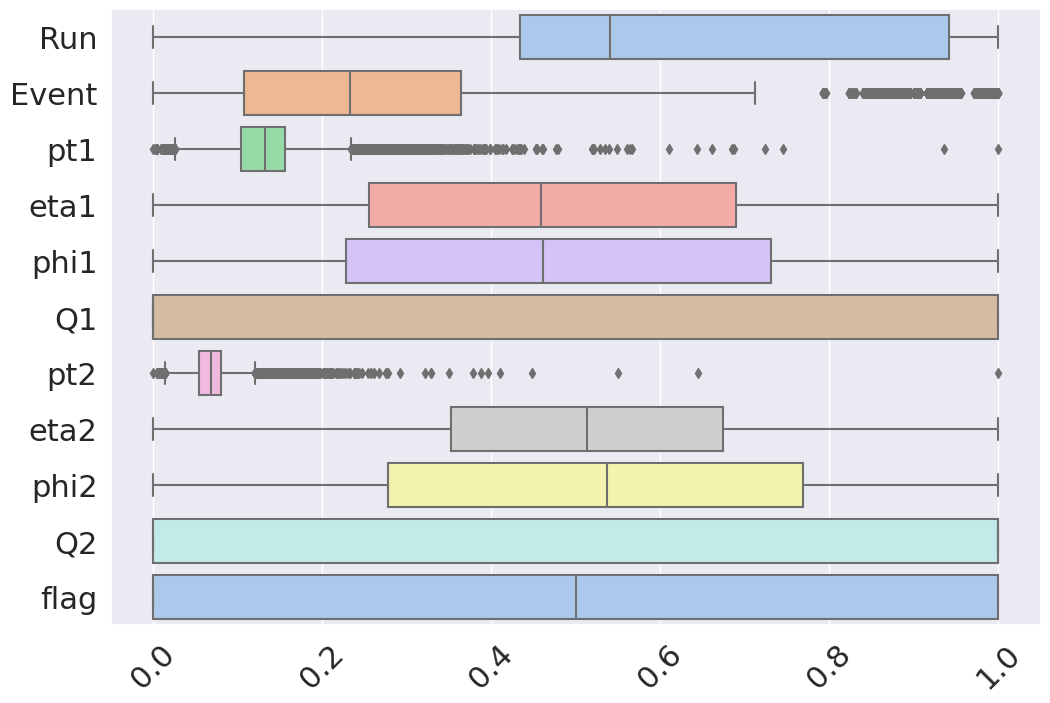

In [12]:
#need to normalise data first to allow better visualisation of the plots
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_all)

plt.figure(figsize=(12, 8))
myplot = sns.boxplot(data=df_scaled, orient='h', palette='pastel')
plt.xticks(rotation=45)
myplot.set_yticklabels(df_all.columns)

plt.show()

While the Event number is not relevant, pt1 and pt2 may need some adjustments since they present outliers. I could take a modified version of the two features.

## Correlation matrix

<Axes: >

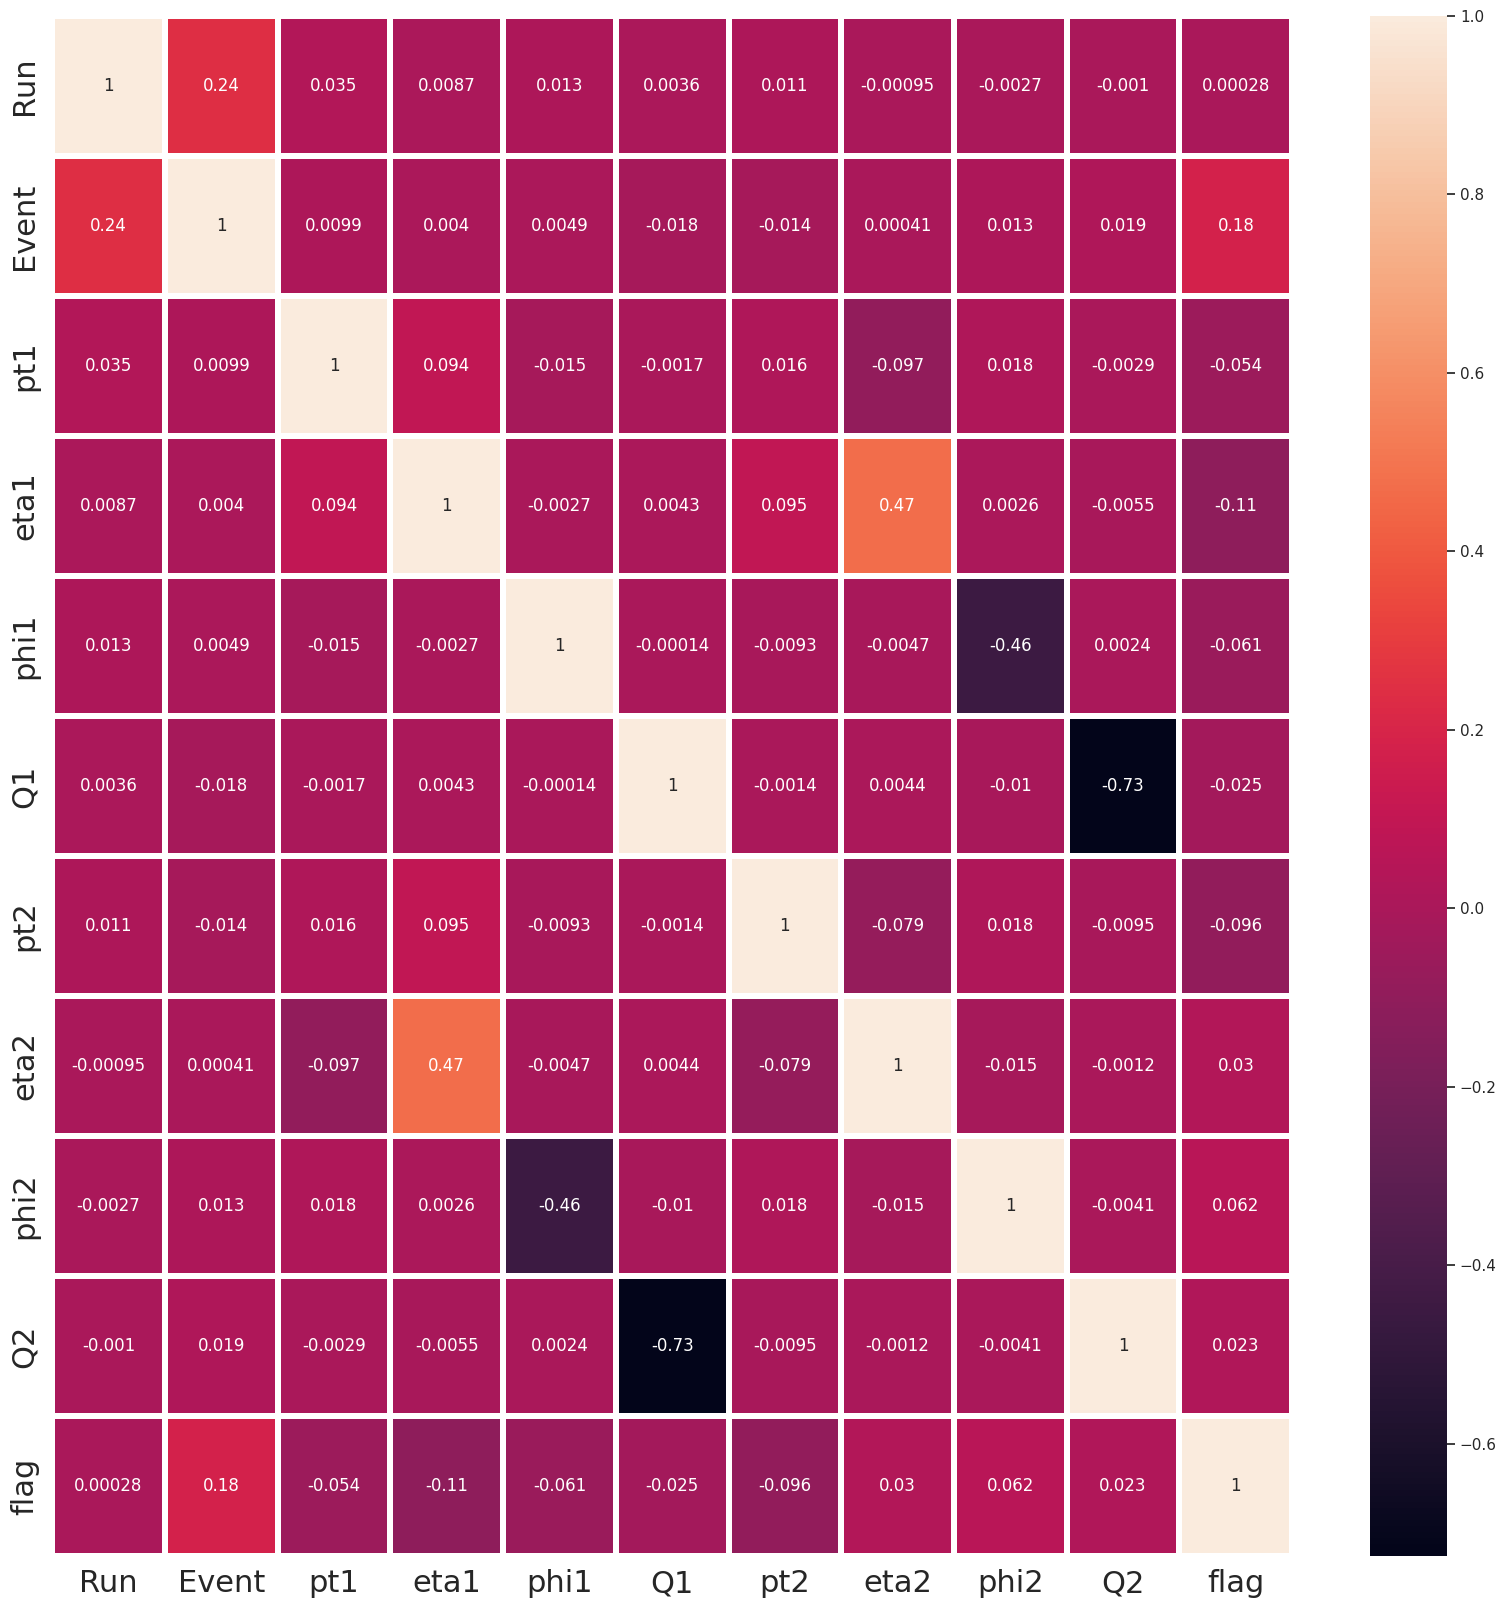

In [13]:
fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=1.0)
sns.heatmap(df_all.corr() , annot= True, linewidths=3, ax=ax)

## Density plots
I am using Seaborn kernel density estimate (KDE) plots. Plotting individually the features of the df I want to use, for clear visualisation.

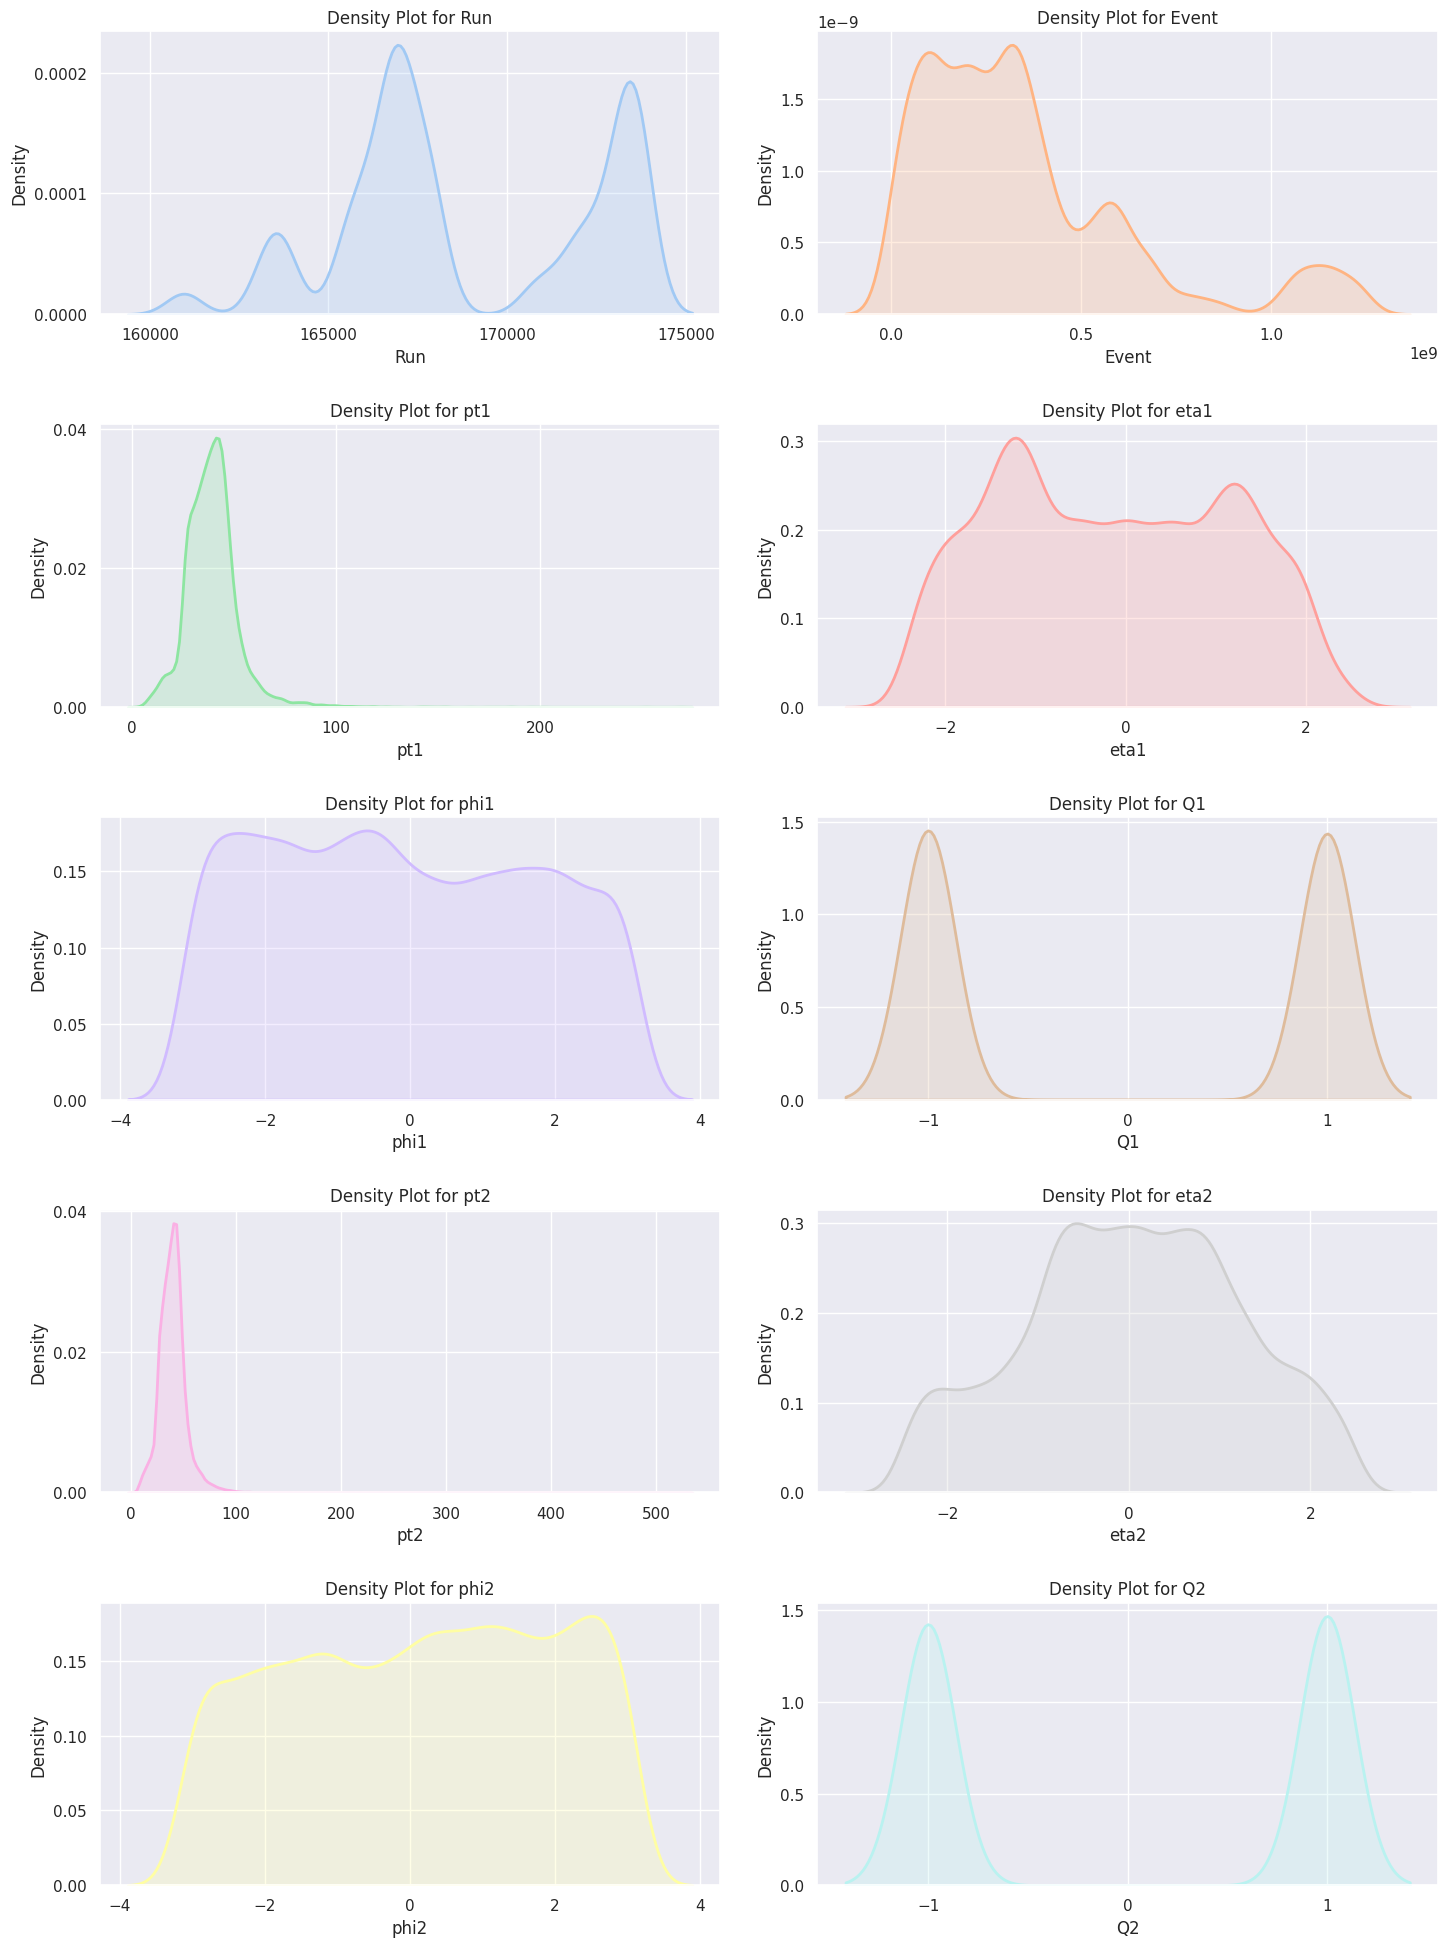

In [14]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()
columns_to_plot = [col for col in df_all.columns if col != 'flag']
sns.set_palette("pastel")
colors=sns.color_palette()
line_width = 2.0
for i, feature in enumerate(columns_to_plot):
    sns.kdeplot(data=df_all[feature], fill=True, ax=axes[i], color=colors[i],linewidth=line_width)
    axes[i].set_title(f'Density Plot for {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
sns.set(font_scale=2.0)
plt.tight_layout()
plt.show()


# Features handling


In [15]:
#what if I take the log of pT, is it better?
df_all_mod = df_all.copy()
df_all_mod["log(pt1)"] = df_all_mod.pt1.apply(np.log)
df_all_mod["log(pt2)"] = df_all_mod.pt2.apply(np.log)
df_all_mod = df_all_mod.drop(['pt1', 'pt2'], axis=1)
#df_all.head()
df_reduced2 = df_all_mod[['eta1', 'phi1', 'eta2', 'phi2', 'flag', 'log(pt1)', 'log(pt2)']]
plt.figure(figsize=(20, 15))
sns.set(font_scale=2.0)

#commenting this because it is slow
#sns.pairplot(df_reduced2, hue="flag", palette="colorblind")

<Figure size 2000x1500 with 0 Axes>

<Axes: >

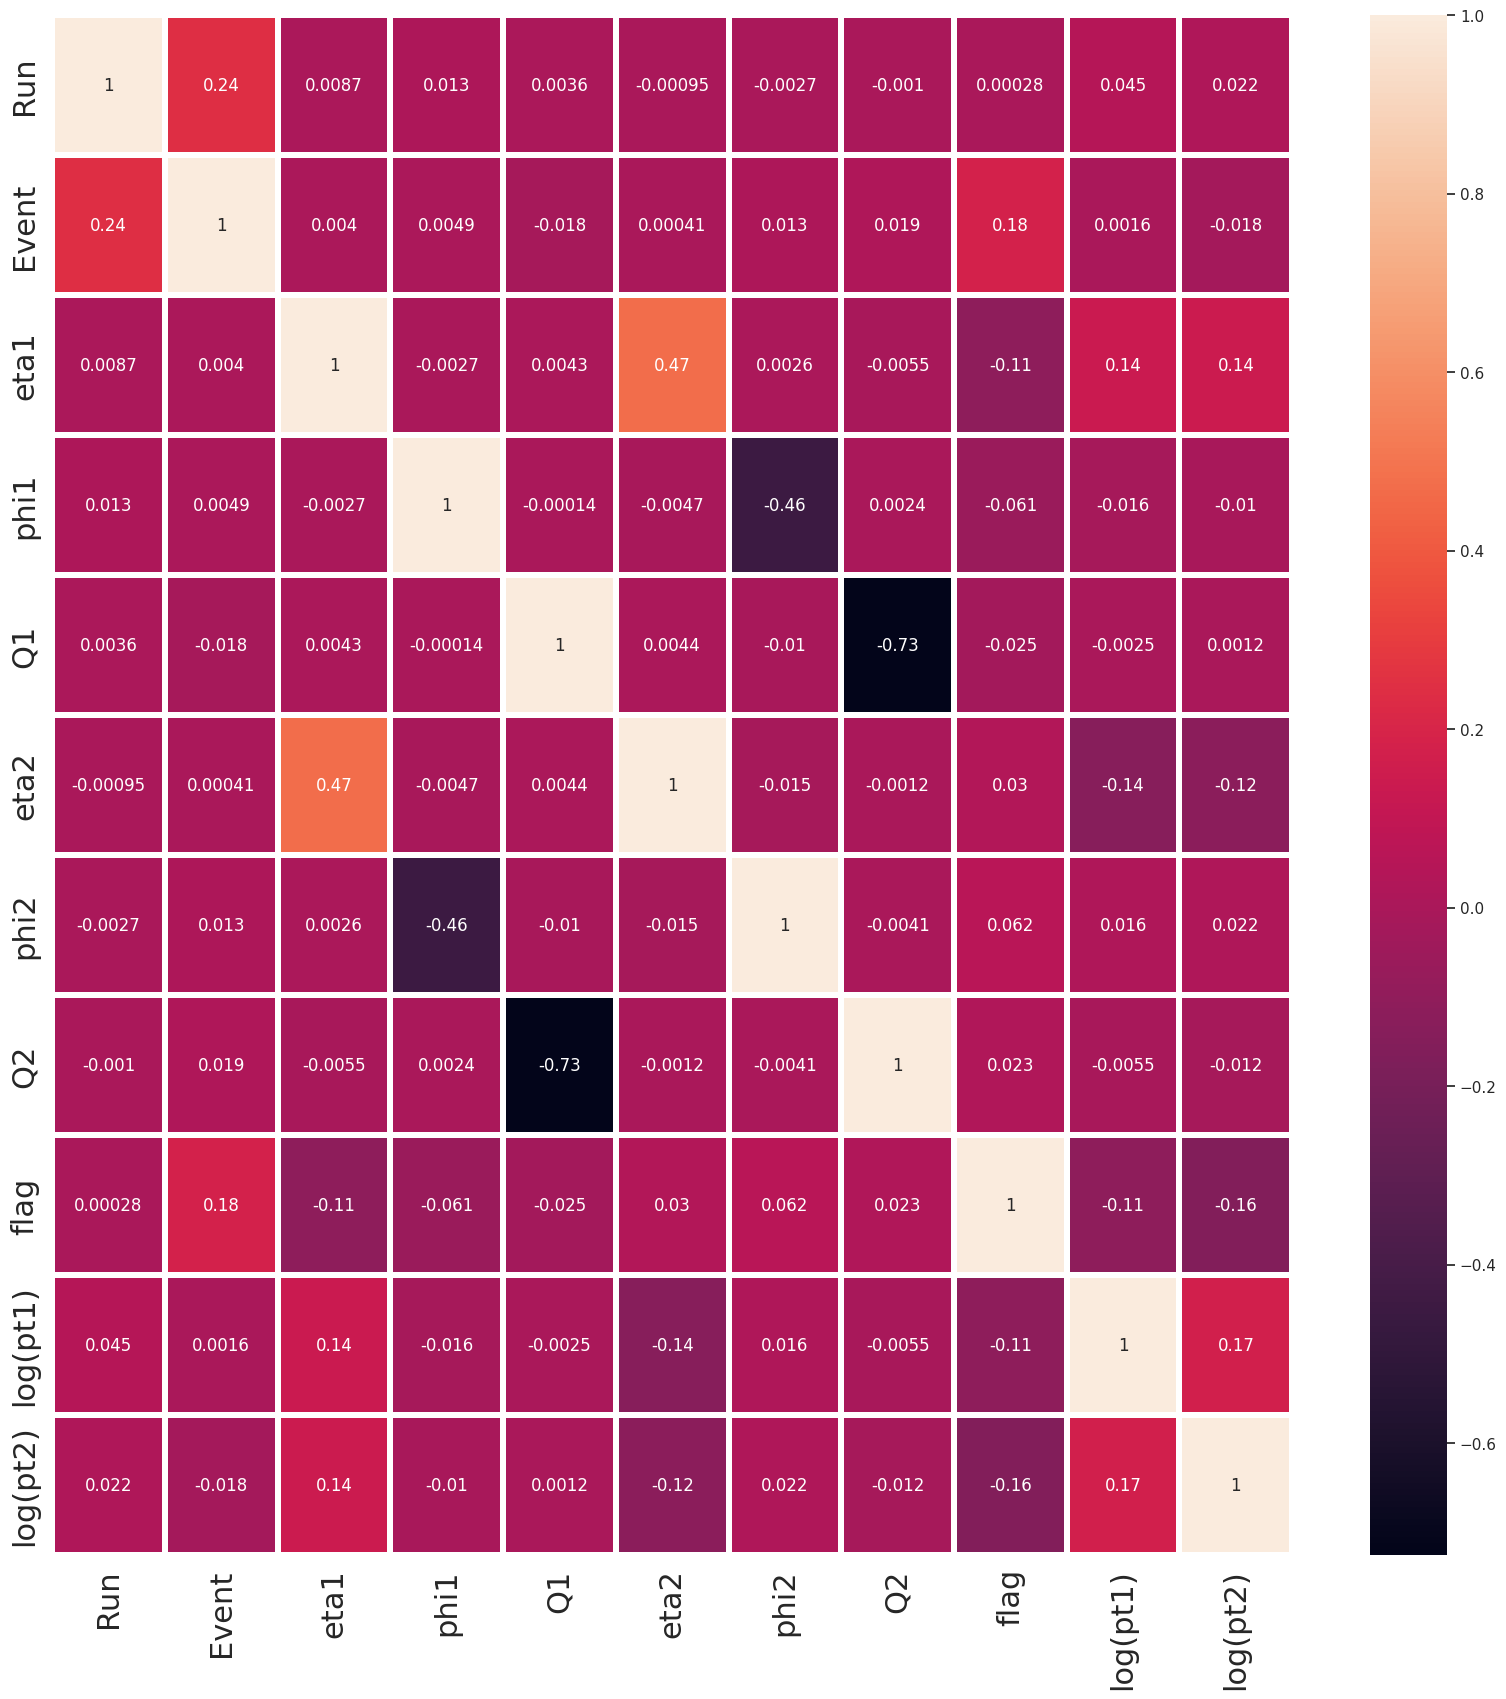

In [16]:
fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=1.0)
sns.heatmap(df_all_mod.corr() , annot= True, linewidths=3, ax=ax)

Using pseudorapidity difference instead of the pìsingle pseudorapidities

In [17]:
#I want to try using the difference in eta and not just eta, out of curiosity
df_all_mod2 = df_all_mod.copy()
df_all_mod2["etaDiff"] = df_all_mod2['eta1'] - df_all_mod2['eta2']
df_all_mod2 = df_all_mod2.drop(['eta1', 'eta2'], axis=1)
#df_all_mod2.head()
df_reduced3 = df_all_mod2[['phi1', 'phi2', 'flag', 'log(pt1)', 'log(pt2)', 'etaDiff']]
plt.figure(figsize=(20, 15))
sns.set(font_scale=2.0)

#commenting this because it is slow
#sns.pairplot(df_reduced3, hue="flag", palette="colorblind")

<Figure size 2000x1500 with 0 Axes>

<Axes: >

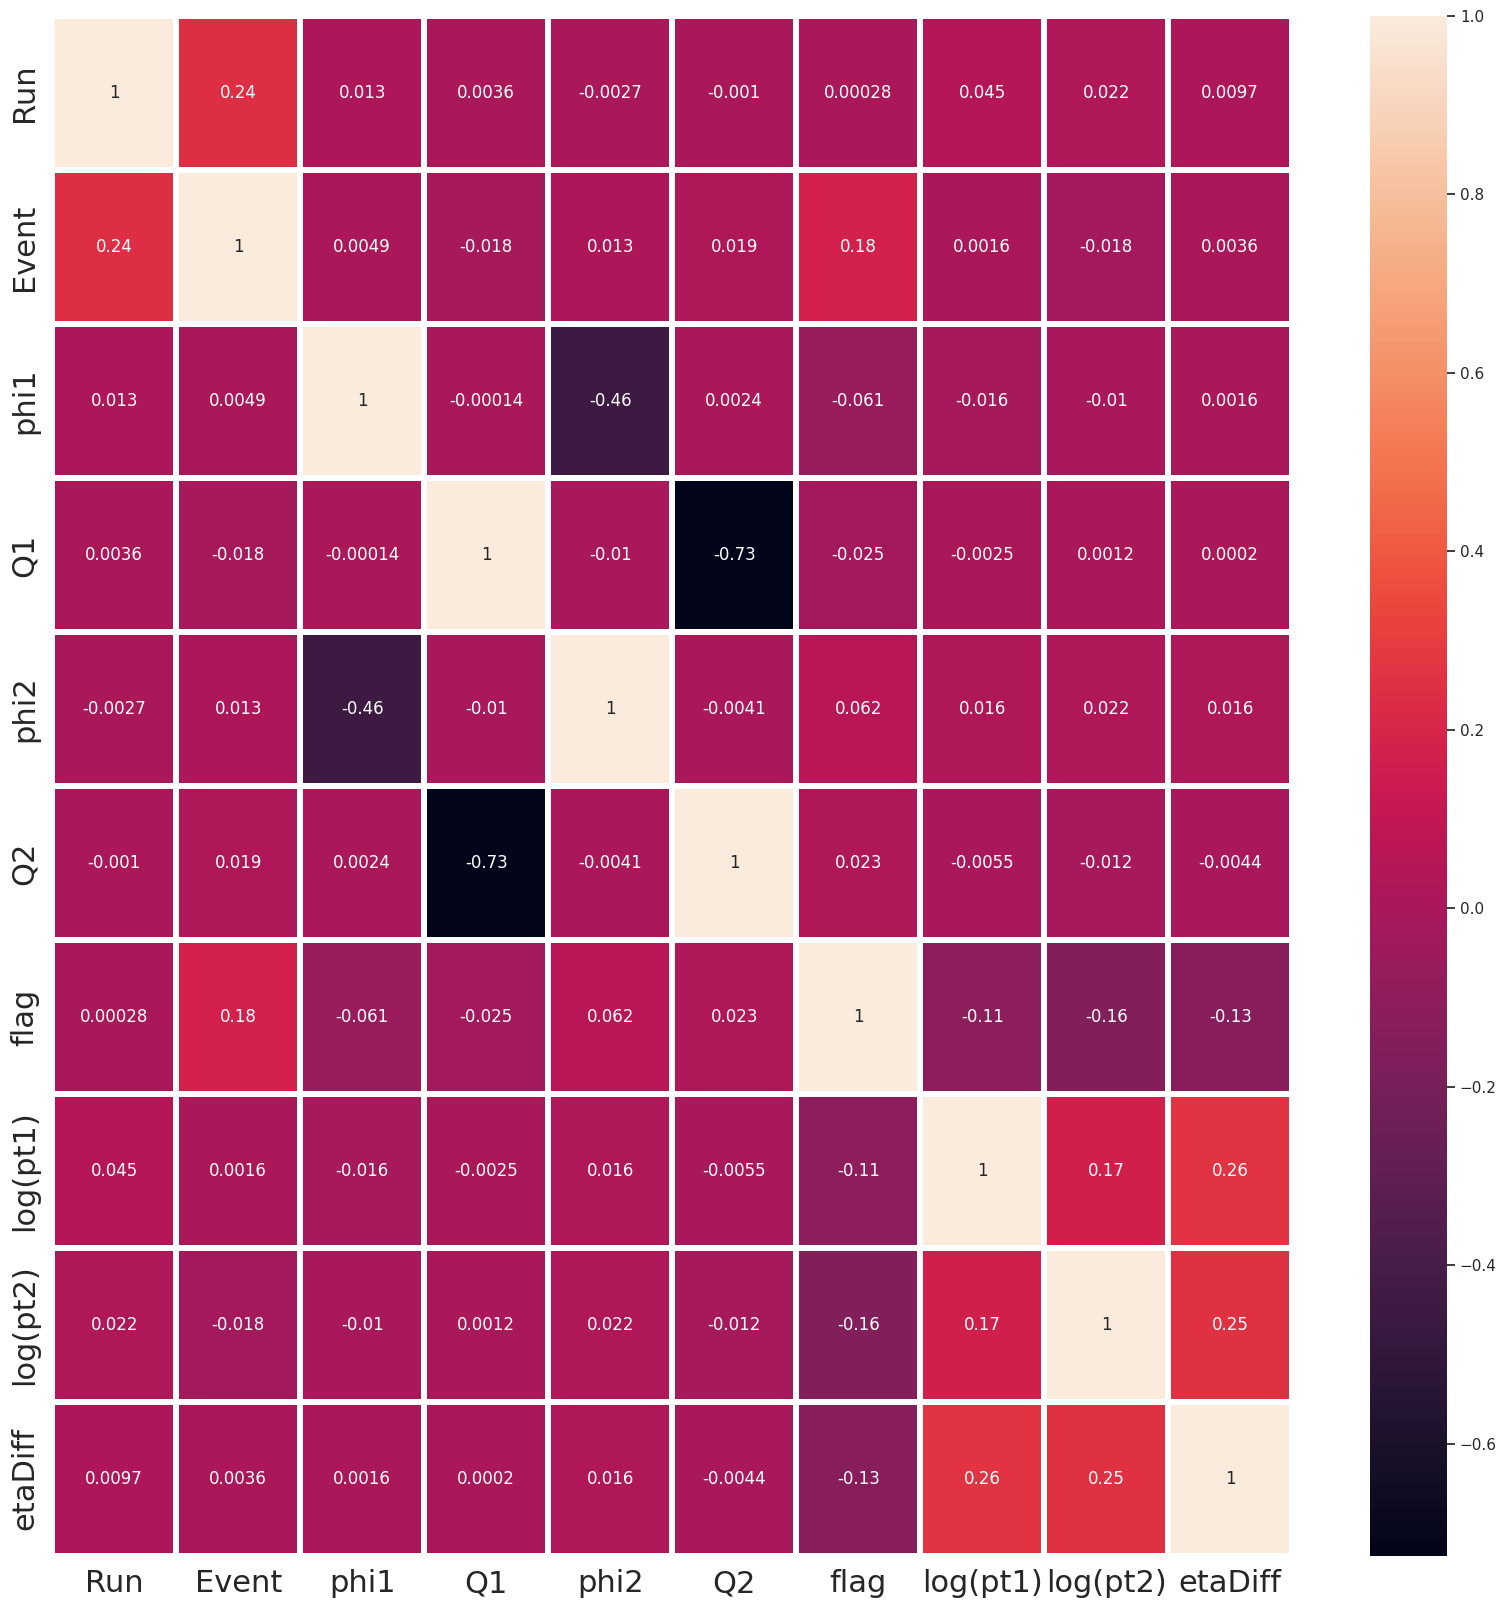

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=1.0)
sns.heatmap(df_all_mod2.corr() , annot= True, linewidths=3, ax=ax)

# Ready for Machine Learning

Let's prepare the data for ML. I am using the dataframe with the log of the pt

First I split the data in train and test sets.

In [19]:
X = df_all_mod.drop(['flag'], axis=1)
y = df_all_mod['flag']
print(f"X shape: {X.shape}")
print(list(X.columns))
print(X)
print(f"y shape: {y.shape}")
print(y.head())



#normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)

train_to_test_ratio = 0.8

X_train, X_test, y_train, y_test = train_test_split(
    rescaledX, y,
    train_size=train_to_test_ratio,
    test_size=1-train_to_test_ratio,
    random_state=42)


X shape: (20000, 10)
['Run', 'Event', 'eta1', 'phi1', 'Q1', 'eta2', 'phi2', 'Q2', 'log(pt1)', 'log(pt2)']
          Run      Event    eta1    phi1  Q1    eta2    phi2  Q2  log(pt1)  \
0      166784   20257329 -1.3248 -3.0057  -1 -0.6624  0.3485   1  3.759175   
1      163261   64679856 -0.0057 -0.7744  -1  1.3710  2.2952   1  3.685735   
2      165570  196860468 -0.4162  0.9198   1 -0.2680 -1.4629   1  4.289495   
3      172163  497791581  0.3063 -1.6034   1 -1.6182  1.5315  -1  3.509860   
4      173692  550966077  0.4276 -0.3876  -1 -0.3080  2.8965   1  3.783794   
...       ...        ...     ...     ...  ..     ...     ...  ..       ...   
19995  163589   25170371  0.0434  2.8371  -1 -0.8716 -0.7647   1  3.667625   
19996  166033  486199311 -1.3922 -1.9531  -1 -0.9045  0.8390   1  3.648682   
19997  173389  687651225 -2.2673 -0.3794  -1 -1.8151  2.9126  -1  3.562863   
19998  172163  191162958 -2.2869  1.4960  -1 -2.1804 -1.0817   1  3.662346   
19999  166895  158156605 -1.3286 -2.

We can start with testing some common classifiers

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s




 ==> RandomForestClassifier
 ======> AUPRC: 0.9993


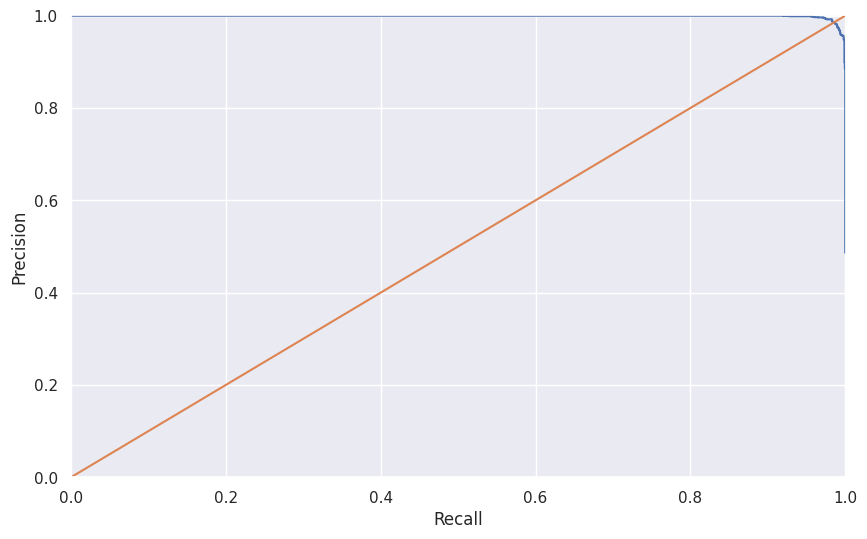

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do



 ==> ExtraTreesClassifier
 ======> AUPRC: 0.9945


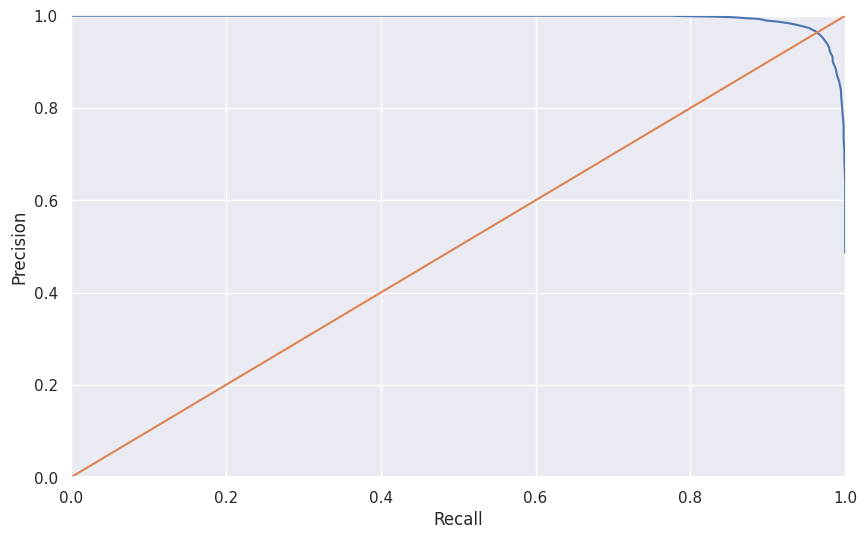

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do



 ==> AdaBoostClassifier
 ======> AUPRC: 0.9870


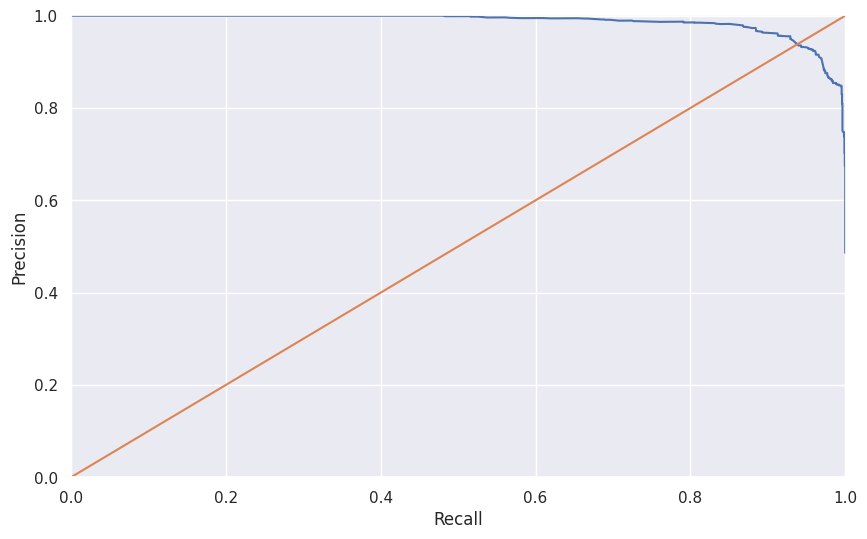



 ==> KNeighborsClassifier
 ======> AUPRC: 0.8829


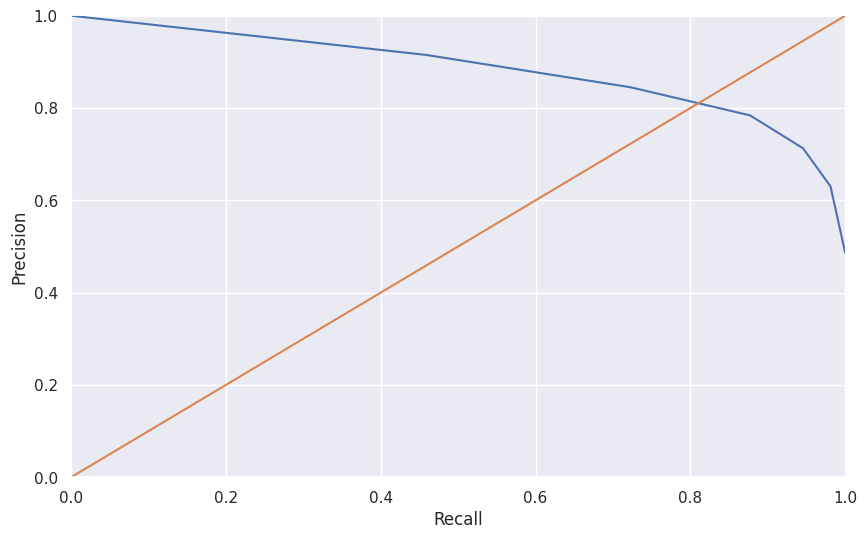



 ==> LogisticRegression
 ======> AUPRC: 0.6759


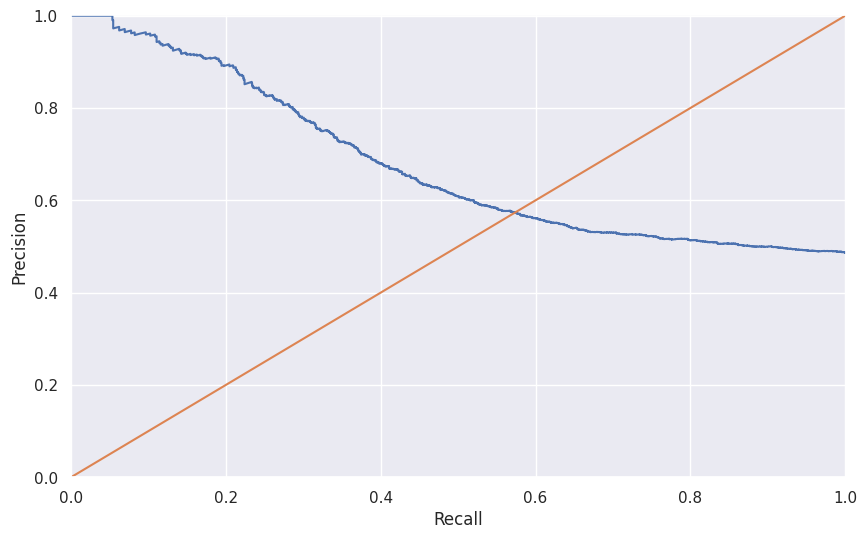

In [20]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

def plot_prc(classif_instance):
  probs = instance.predict_proba(X_test)[:, 1]
  prec, recall, thres = precision_recall_curve(y_test, probs)
  instance_text = f"{instance}"
  clf_name = instance_text.partition("(")[0]
  print("\n\n ==>", clf_name)
  print(f" ======> AUPRC: {auc(recall, prec):0.4f}")
  fig = plt.figure(figsize=(10, 6))
  plt.plot(recall, prec)
  plt.plot([0, 1], [0, 1])
  plt.xlim(0, 1.001)
  plt.ylim(0, 1.001)
  plt.ylabel("Precision")
  plt.xlabel("Recall")
  plt_name = f"pr_{clf_name}.png"
  filepath_imm = os.path.join(images_dir, plt_name)
  fig.savefig(filepath_imm, facecolor='white',transparent=False )
  plt.show()


#Preparing save directory for plots
images_dir = './images_Classifiers'
if not os.path.isdir(images_dir):
    os.makedirs(images_dir)


clf_dict = {
    RandomForestClassifier: dict(min_samples_split=10, n_estimators=50, warm_start=True, verbose=1),
    ExtraTreesClassifier: dict(n_estimators=50, verbose=1),
    AdaBoostClassifier: dict(n_estimators=50),
    KNeighborsClassifier: dict(n_neighbors = 5),
    LogisticRegression: dict(random_state=42),
 }

results = []
names = []

for clf in clf_dict:

  instance = clf(**clf_dict[clf])
  instance.fit(X_train, y_train)
  plot_prc(instance)

  #these lines are useful for the boxplot plot
  clf_name = clf.__name__
  names.append(clf_name)
  kfold = KFold(n_splits=10, random_state=7, shuffle=True)
  cv_results = cross_val_score(instance, X, y, cv=kfold, scoring='accuracy')
  results.append(cv_results)




Which is working better and is worth having a deeper look into?

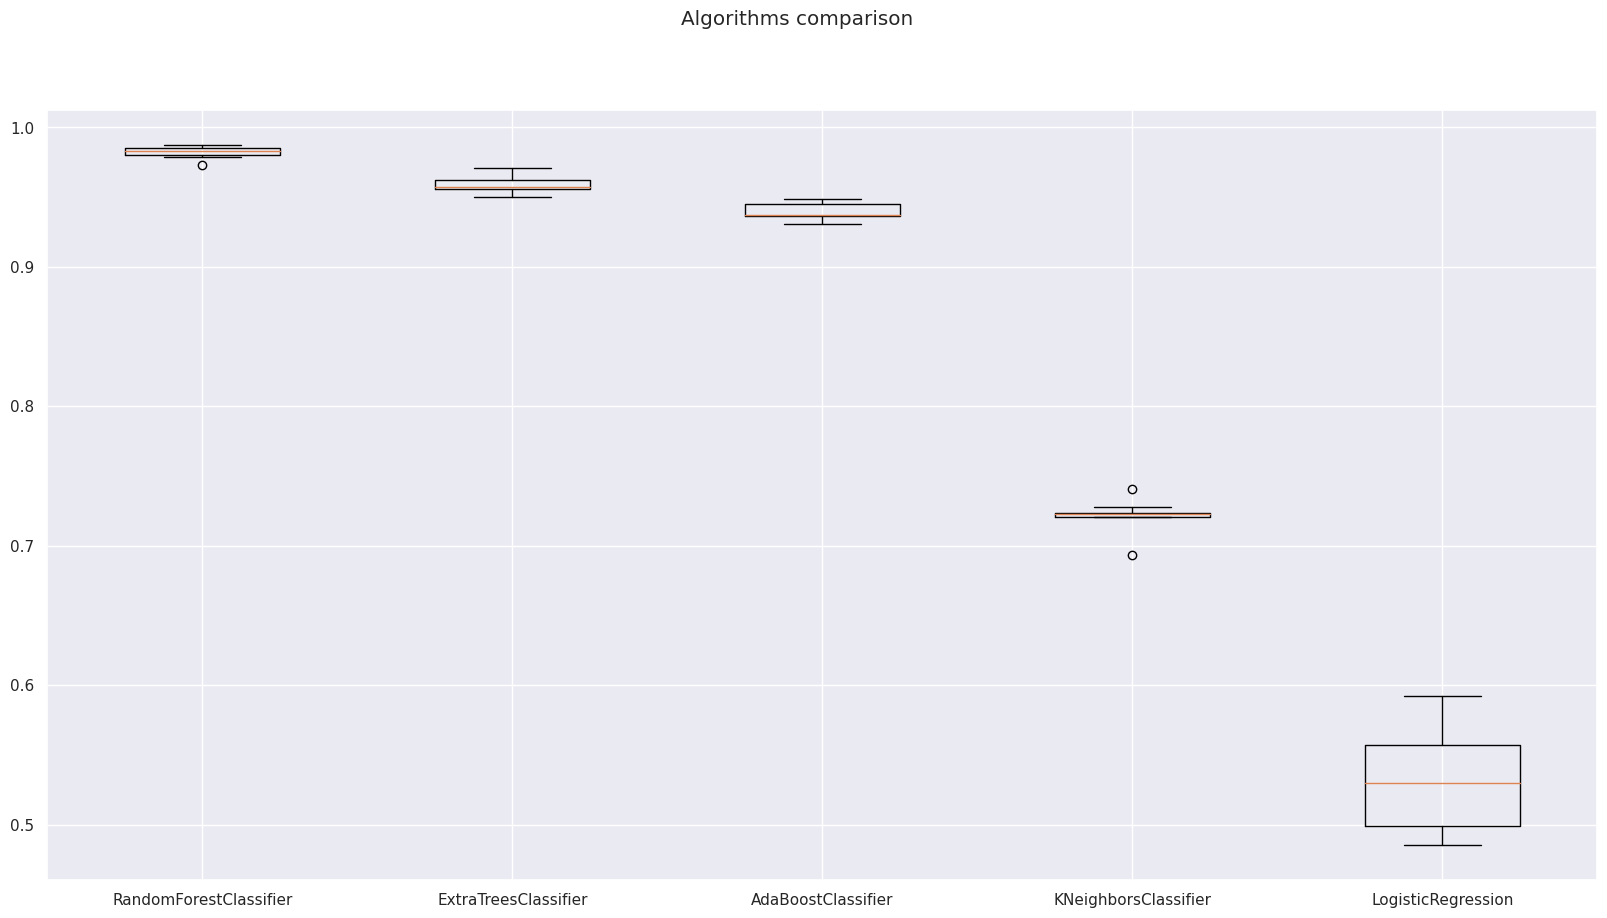

In [21]:
# boxplot algorithm comparison
from matplotlib import pyplot
fig = pyplot.figure(figsize=(20, 10))
fig.suptitle('Algorithms comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

# Improving the classifiers hyperparameters

I may want to look at the learning curves for better optimisation so I define a function to plot them

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import HistGradientBoostingClassifier


def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 20)):
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=18)
    plt.xlabel("Training Examples", fontsize=14)
    plt.ylabel("Score", fontsize=14)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    # Use similar fill and line colors as in plot_classifier_training_curves
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="blue")  # Use 'b' (blue) for training score
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#E76B0B")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue",
             label="Training Score", markersize=5)
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#E76B0B",
             label="Cross-Validation Score", markersize=5)

    # Customize legend, labels, and ticks
    plt.legend(loc="best", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)

    return plt



### KNeighborsClassifier
This classifier is performing not so great, let's find a better number of neighbours

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

X_train1, X_val, y_train1, y_val = train_test_split(
    rescaledX, y,
    train_size=train_to_test_ratio,
    test_size=1-train_to_test_ratio,
    random_state=42)

param_grid = {'n_neighbors': [2, 4, 6, 8, 10, 12, 16, 18, 20]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Best number of neighbours: {best_n_neighbors}")
best_KNC = KNeighborsClassifier(n_neighbors=best_n_neighbors)
best_KNC.fit(X_train1, y_train1)
y_pred = best_KNC.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Best AUPRC: {accuracy}")

Best number of neighbours: 10
Best AUPRC: 0.8315


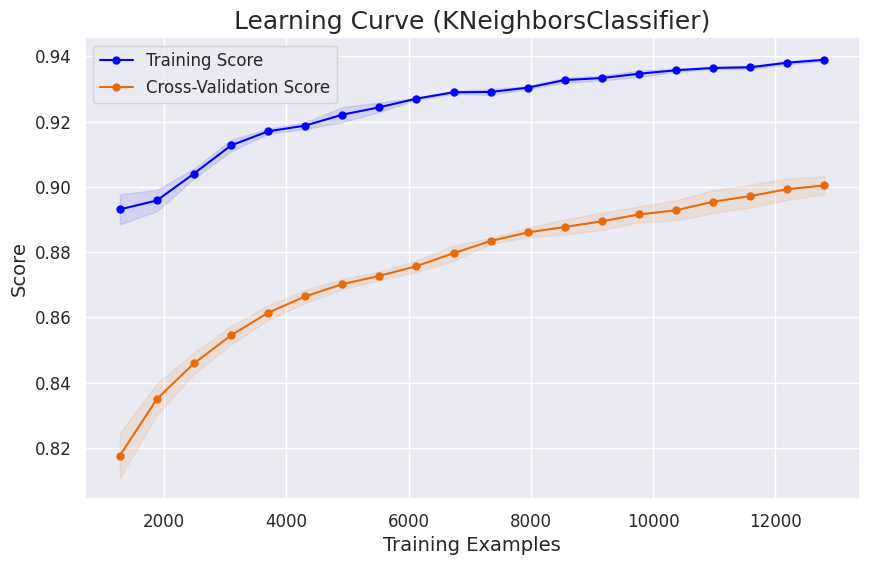

In [24]:
#KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 10)
title = "Learning Curve (KNeighborsClassifier)"
plot_learning_curve(clf, title, X_train, y_train, cv=5,train_sizes=np.linspace(0.1, 1.0, 20))
plt.show()

I do not think this classifier is suitable for my data given the nature of my dataset and the charactersitics of the classifier (dataset is small but there is no particular pattern in which distance could be useful to measure similarity among data pints)

### AdaBoostClassifier


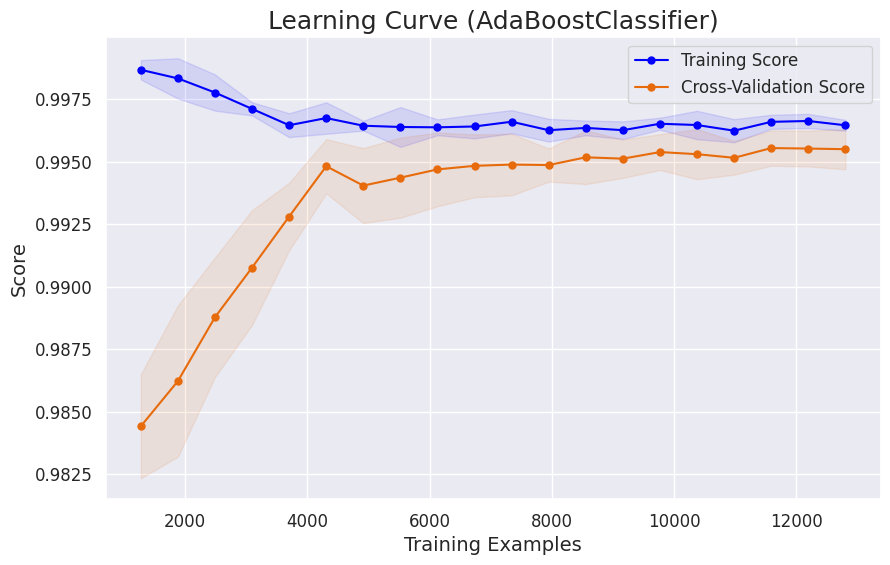

In [25]:
clf = AdaBoostClassifier(n_estimators=100)

# Plot the learning curve
title = "Learning Curve (AdaBoostClassifier)"
plot_learning_curve(clf, title, X_train, y_train, cv=5)

plt.show()

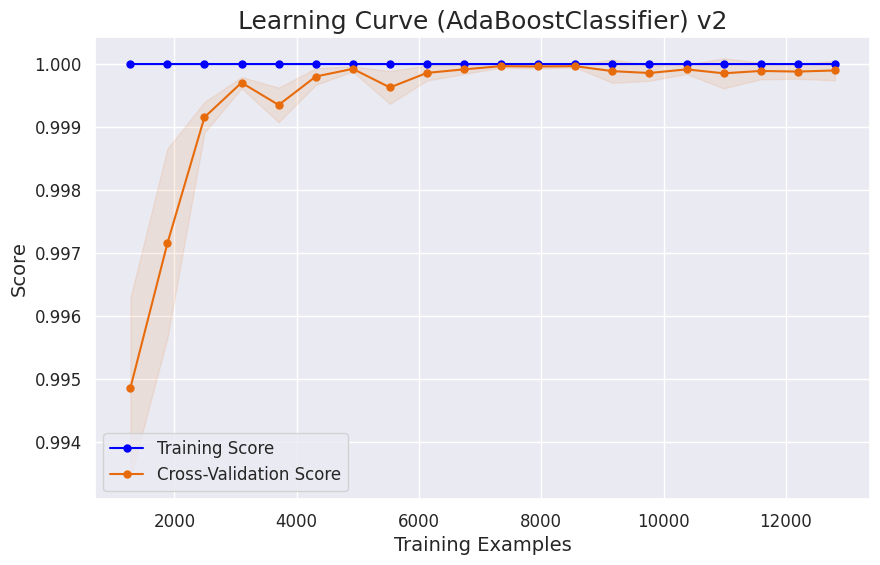

In [26]:
#AdaBoostClassifier version 2 to increase model complexity (is this an overkill for this dataset?)

from sklearn.tree import DecisionTreeClassifier
clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=50)
title = "Learning Curve (AdaBoostClassifier) v2"
plot_learning_curve(clf, title, X_train, y_train, cv=5)

plt.show()

Let's see the AUPRC



 ==> AdaBoostClassifier
 ======> AUPRC: 1.0000


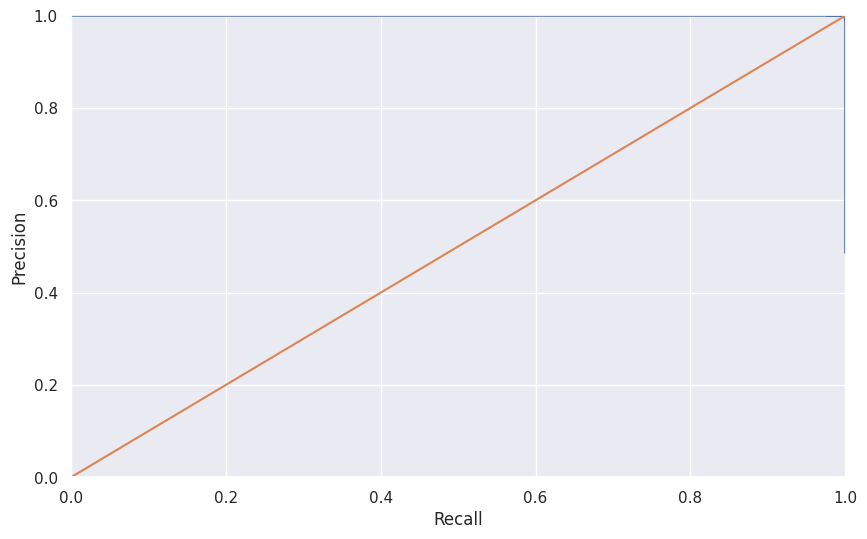

In [27]:
from sklearn.tree import DecisionTreeClassifier

clf_dict = {
  AdaBoostClassifier: dict(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=50),
}

for clf in clf_dict:

  instance = clf(**clf_dict[clf])
  instance.fit(X_train, y_train)
  plot_prc(instance)

### LogisticRegression

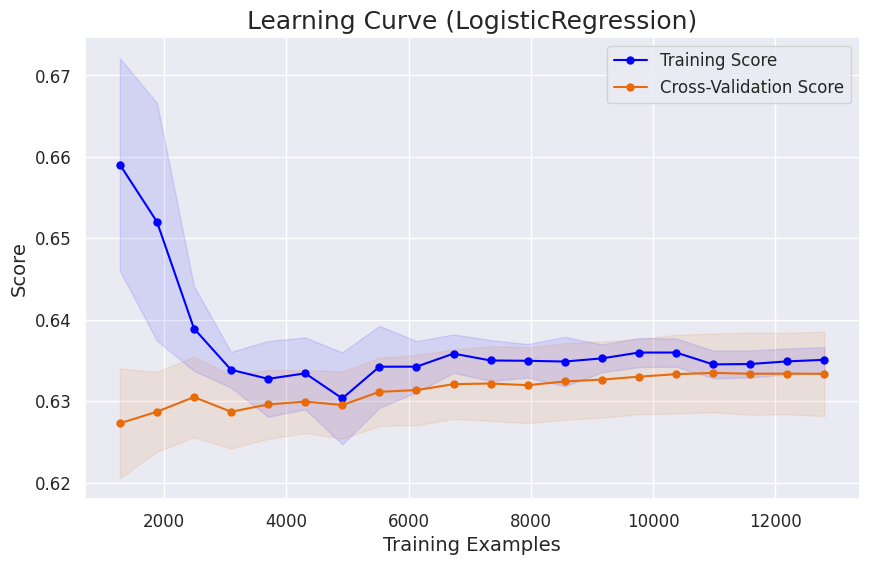

In [28]:
clf = LogisticRegression(random_state=42, solver='liblinear')
title = "Learning Curve (LogisticRegression)"
plot_learning_curve(clf, title, X_train, y_train, cv=5,train_sizes=np.linspace(0.1, 1.0, 20))
plt.show()

I want to try a Randomized search CV which can be convenient given the small dataset I have

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Parameters:  {'penalty': 'l1', 'max_iter': 200, 'C': 0.06579332246575682}
Best Score:  0.5950627585390191
 ======> AUPRC: 0.6751


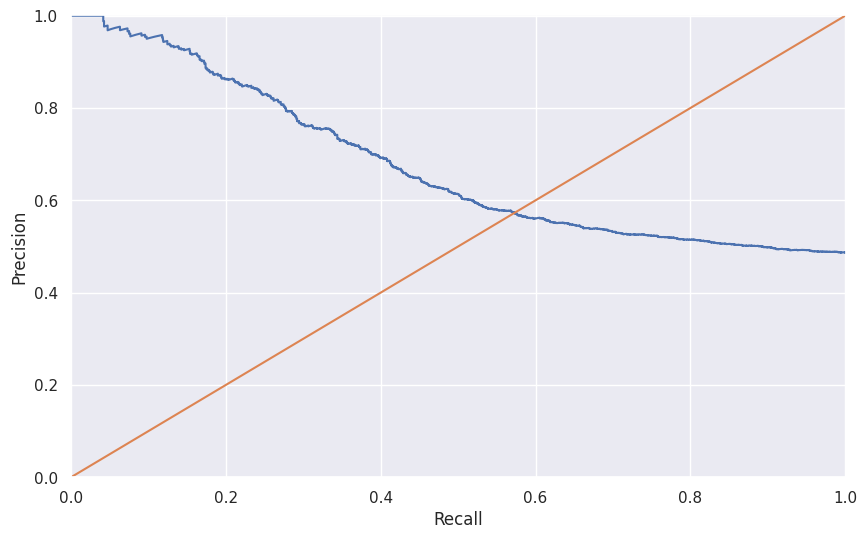

In [29]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'C': np.logspace(-3, 3, 100),  # A range of C values in a logarithmic scale
    'penalty': ['l1', 'l2'],
    'max_iter': [50, 100, 200],
}


random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

best_model = random_search.best_estimator_


probs = best_model.predict_proba(X_test)[:, 1]
prec, recall, thres = precision_recall_curve(y_test, probs)
print(f" ======> AUPRC: {auc(recall, prec):0.4f}")
fig = plt.figure(figsize=(10, 6))
plt.plot(recall, prec)
plt.plot([0, 1], [0, 1])
plt.xlim(0, 1.001)
plt.ylim(0, 1.001)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

A logistic regression, given the distribution of my features, is not an optimal choice

### RandomForestClassifier



Learning curve of the classifier as it is does not have the samples which converge that well, let's see if I can improve that

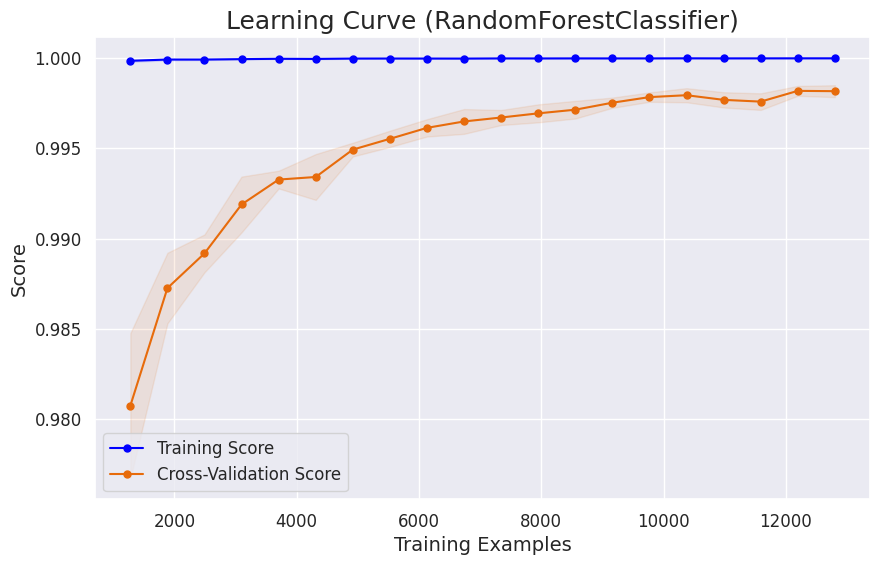

In [30]:
clf = RandomForestClassifier(min_samples_split=10, n_estimators=50, warm_start=True, verbose=1)
title = "Learning Curve (RandomForestClassifier)"
plot_learning_curve(clf, title, X_train, y_train, cv=5)
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40}
Best Score: 0.9800625193742776
 ======> AUPRC: 0.9990


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


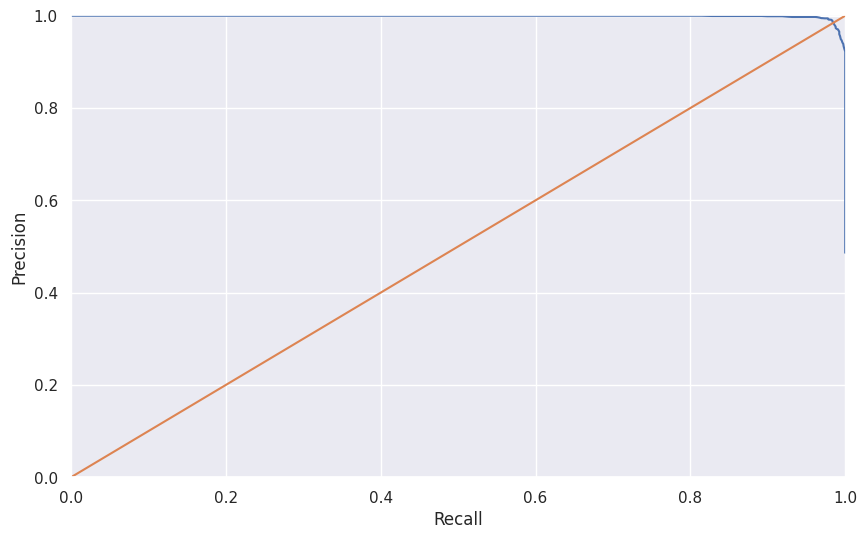

In [31]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [70, 100, 120],
    'min_samples_split': [2, 5, 7],
    'max_depth': [30, 40, 60],
    'min_samples_leaf': [1, 2, 4],
}
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

best_model = random_search.best_estimator_

probs = best_model.predict_proba(X_test)[:, 1]
prec, recall, thres = precision_recall_curve(y_test, probs)
print(f" ======> AUPRC: {auc(recall, prec):0.4f}")
fig = plt.figure(figsize=(10, 6))
plt.plot(recall, prec)
plt.plot([0, 1], [0, 1])
plt.xlim(0, 1.001)
plt.ylim(0, 1.001)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

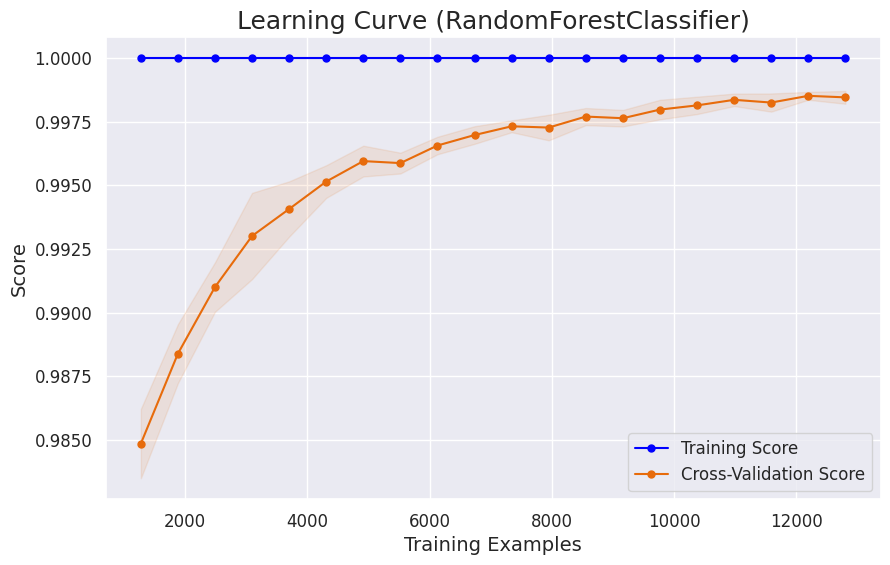

In [32]:
title = "Learning Curve (RandomForestClassifier)"
plot_learning_curve(best_model, title, X_train, y_train)
plt.show()

# Implementation of a NN

I define functions for plotting, useful for my NN models

In [119]:
def make_prcurve(model):
  y_pred = model.predict(X_test)
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  average_precision = average_precision_score(y_test, y_pred)
  plt.figure(figsize=(10, 6))
  plt.plot(recall, precision, marker='.')
  plt.plot([0, 1], [0, 1])
  plt.xlim(0, 1.001)
  plt.ylim(0, 1.001)
  plt.ylabel('Precision')
  plt.xlabel('Recall')
  plt.title(f'Average PRC={average_precision:.3f}')
  plt.grid(True)
  plt.show()

In [120]:
import tensorflow as tf
from sklearn.metrics import average_precision_score

def my_NN():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu',),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

model = my_NN()
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
500/500 [==============================] - 1s 2ms/step - loss: 0.5987 - accuracy: 0.6661 - val_loss: 0.5281 - val_accuracy: 0.7197
Epoch 2/20
500/500 [==============================] - 1s 1ms/step - loss: 0.4972 - accuracy: 0.7552 - val_loss: 0.4778 - val_accuracy: 0.7690
Epoch 3/20
500/500 [==============================] - 1s 1ms/step - loss: 0.4619 - accuracy: 0.7789 - val_loss: 0.4519 - val_accuracy: 0.7860
Epoch 4/20
500/500 [==============================] - 1s 1ms/step - loss: 0.4467 - accuracy: 0.7862 - val_loss: 0.4458 - val_accuracy: 0.7862
Epoch 5/20
500/500 [==============================] - 1s 1ms/step - loss: 0.4352 - accuracy: 0.7954 - val_loss: 0.4246 - val_accuracy: 0.8043
Epoch 6/20
500/500 [==============================] - 1s 1ms/step - loss: 0.4201 - accuracy: 0.8041 - val_loss: 0.4268 - val_accuracy: 0.8005
Epoch 7/20
500/500 [==============================] - 1s 1ms/step - loss: 0.4100 - accuracy: 0.8074 - val_loss: 0.4093 - val_accuracy: 0.8090
Epoch 

125/125 [==============================] - 0s 764us/step


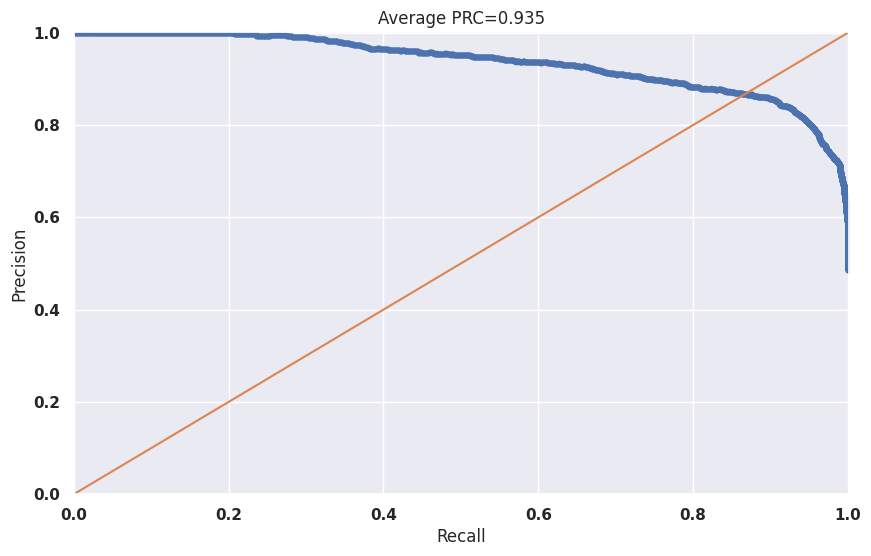

In [121]:
make_prcurve(model)

125/125 - 0s - loss: 0.3093 - accuracy: 0.8633 - 105ms/epoch - 837us/step


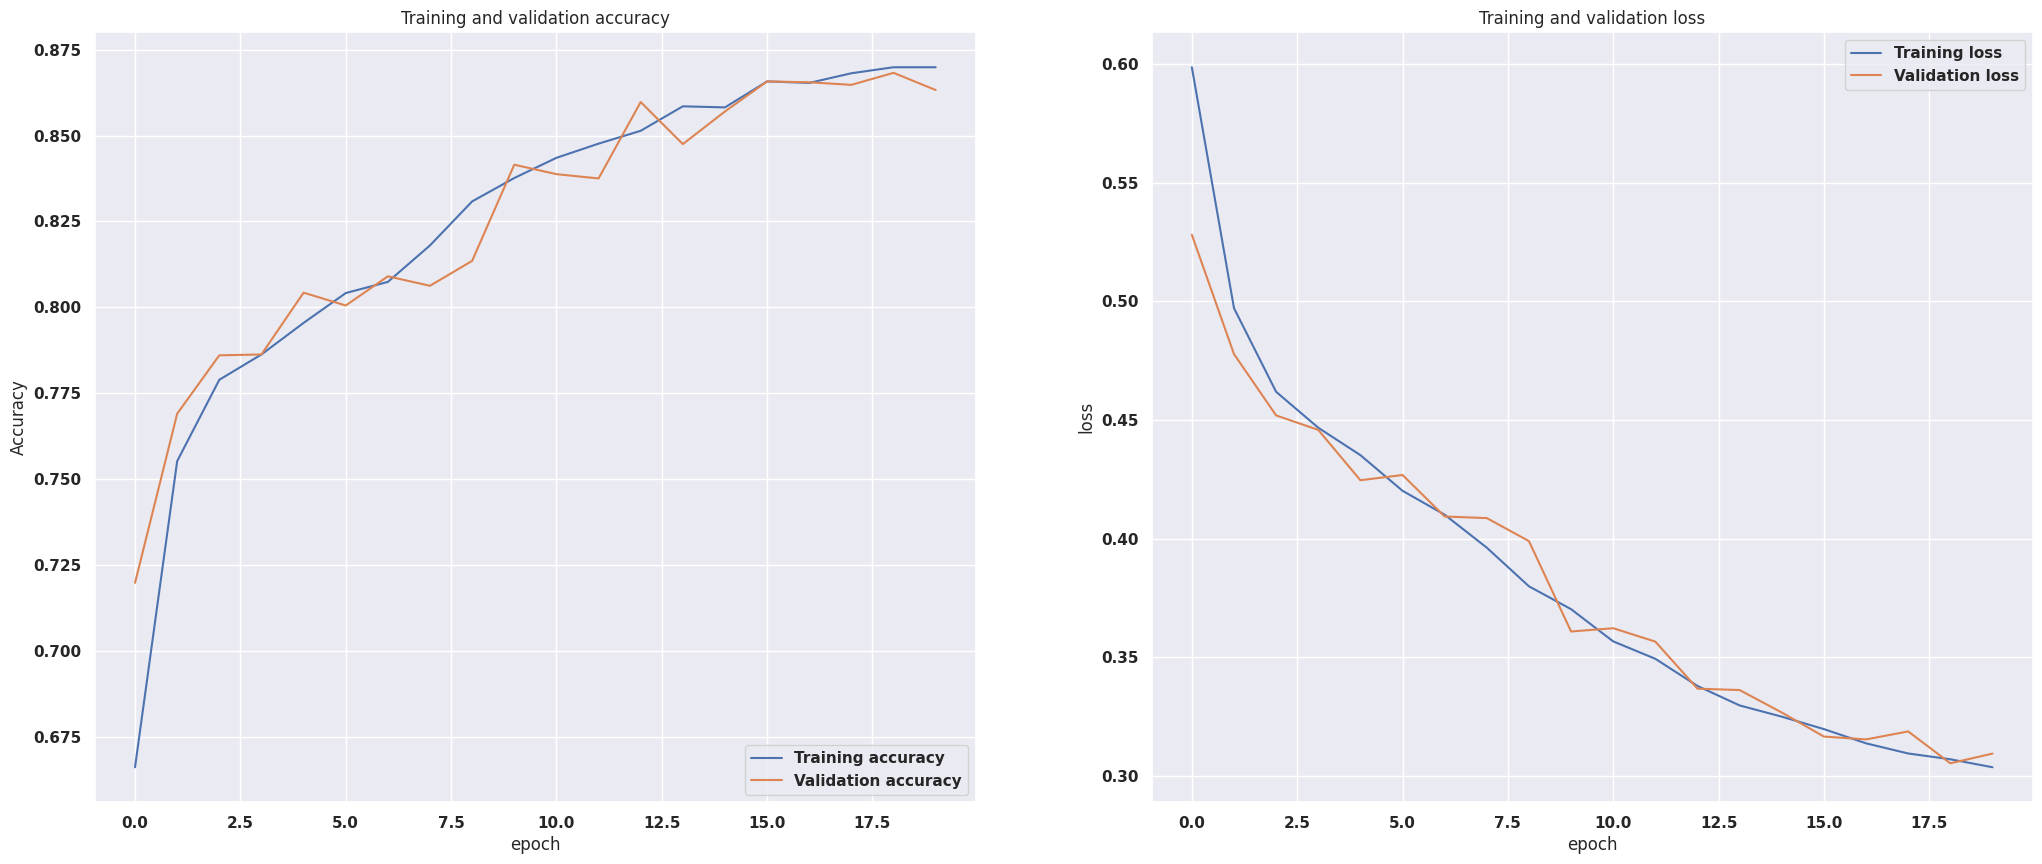

In [122]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(25,10))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(history.history['accuracy'], label='Training accuracy')
ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy')
ax1.set_title("Training and validation accuracy")
ax1.set(xlabel='epoch', ylabel='Accuracy')
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='Training loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.set_title("Training and validation loss")
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(loc='upper right')
#To check the network accuracy on test data
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

I try to change the model to make it perform better (my dataset is not so big).
I look at AUPRC and I save the best model parameters.

In [127]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger
from tensorflow.keras.metrics import AUC
from keras.models import Sequential
from sklearn.metrics import accuracy_score


def my_NN():
    model = Sequential([
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc', curve='PR')])
    return model

model = my_NN()

#defining callbacks
save_dir ='model_checkpoints'
model_name = 'model-auc{val_auc:0.4f}-epoch{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

model_checkpoint = ModelCheckpoint(filepath=filepath, save_best_only=True, monitor='val_auc', mode='max', verbose=1)
#I played with this to see if it was needed but I do not think so, NN is quite small, low number of epochs
#early_stopping = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, verbose=1)
progress_bar = ProgbarLogger()

#callbacks = [model_checkpoint, progress_bar, early_stopping]
callbacks = [model_checkpoint, progress_bar]


#fitting
history = model.fit(X_train, y_train, batch_size=32, epochs=50,
                    validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
      0/Unknown - 1s 0s/sample - loss: 0.5572 - accuracy: 0.7008 - auc: 0.7776
Epoch 1: val_auc improved from -inf to 0.81344, saving model to model_checkpoints/model-auc0.8134-epoch001.h5
500/500 [==============================] - 2s 4ms/sample - loss: 0.5572 - accuracy: 0.7007 - auc: 0.7772 - val_loss: 0.5221 - val_accuracy: 0.7230 - val_auc: 0.8134
Epoch 2/50
  0/500 [..............................] - ETA: 0s - loss: 0.4776 - accuracy: 0.7606 - auc: 0.8401
Epoch 2: val_auc improved from 0.81344 to 0.84606, saving model to model_checkpoints/model-auc0.8461-epoch002.h5
500/500 [==============================] - 1s 2ms/sample - loss: 0.4762 - accuracy: 0.7611 - auc: 0.8415 - val_loss: 0.4687 - val_accuracy: 0.7625 - val_auc: 0.8461
Epoch 3/50
  0/500 [..............................] - ETA: 0s - loss: 0.4547 - accuracy: 0.7794 - auc: 0.8548
Epoch 3: val_auc improved from 0.84606 to 0.85505, saving model to model_checkpoints/model-auc0.8551-epoch003.h5
500/500 [===============

125/125 [==============================] - 0s 776us/step


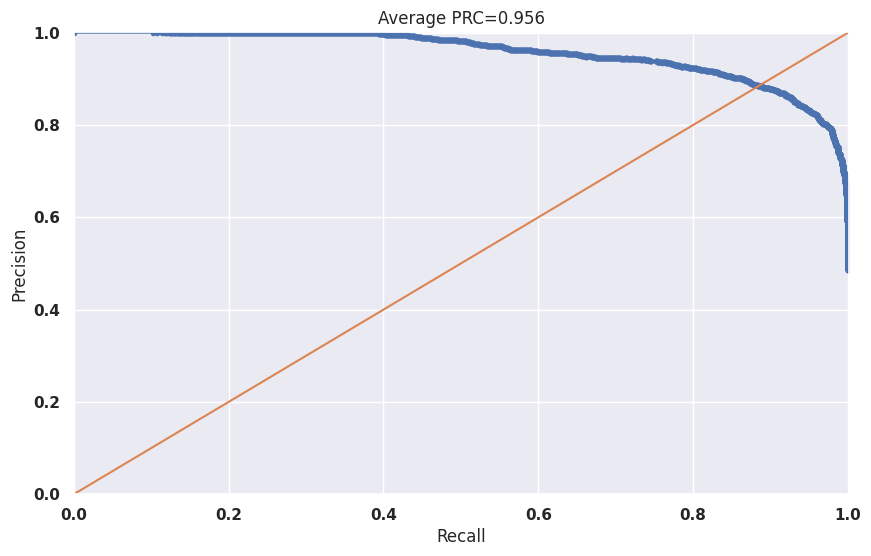

In [128]:
make_prcurve(model)

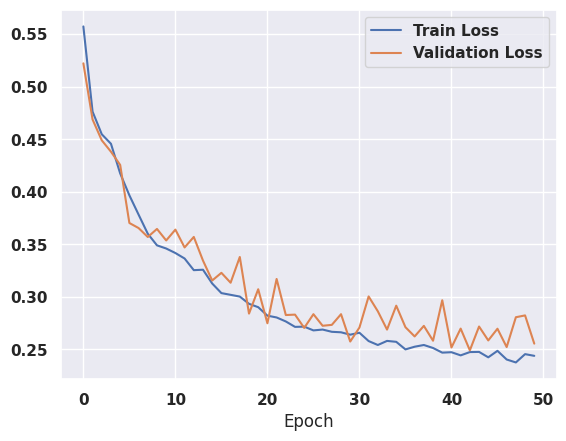

In [129]:
fig = plt.figure()
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.legend()

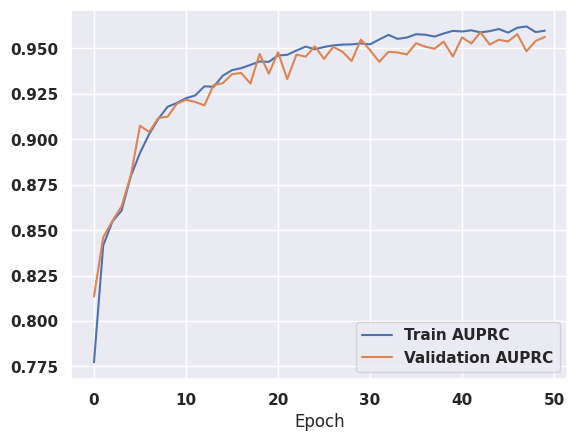

In [130]:
fig = plt.figure()
plt.plot(history.history['auc'], label="Train AUPRC")
plt.plot(history.history['val_auc'], label="Validation AUPRC")
plt.xlabel("Epoch")
plt.legend()

The network weights from the best model are retreived

model_checkpoints/model-auc0.9591-epoch048.h5
 =========> Best AUC:  0.9591776819376986


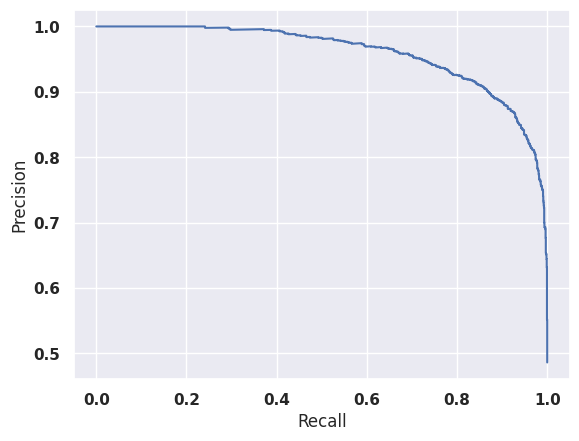

In [131]:
! ls -1 model_checkpoints/*model*.h5 | sort -n | tail -n 1
!cp $(ls -1 model_checkpoints/*model*.h5 | sort -n | tail -n 1) model_checkpoints/last.h5

model.load_weights("model_checkpoints/last.h5")
probs = model.predict_on_batch(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, probs)

fig = plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
print(" =========> Best AUC: ", auc(recall, precision))

Let's see the confusion matrix

125/125 [==============================] - 0s 838us/step


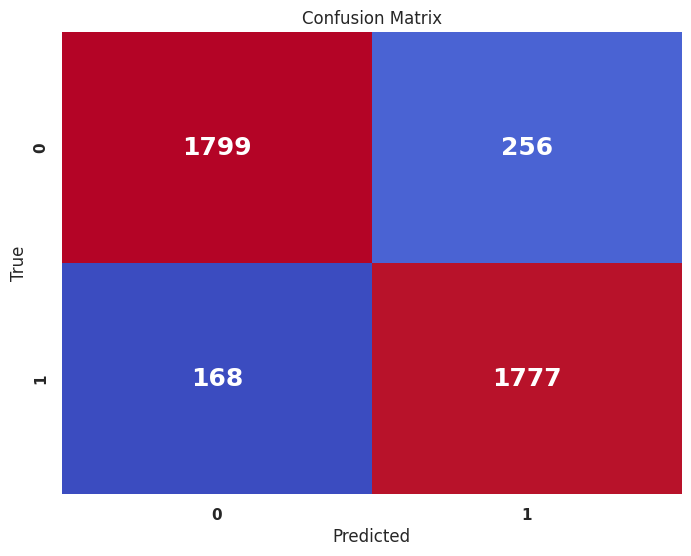

In [132]:
from sklearn.metrics import confusion_matrix

y_test_binary = (y_test > 0.5).astype(int)
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

confusion_mat = confusion_matrix(y_test_binary, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap="coolwarm", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()